# Specialized Neural Networks

This notebook shows how to use a pipeline of distinct neural networks to predict
secondary structures.

Specialized models are used to:

- Determine the general aspect of the secondary structure
- Determine the precise pairings of the secondary structure
- Estimate the quality of the structure.

In [1]:
import numpy as np
from diurnal import database, structure, train, utils, transform, visualize

## Data Preparation

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-02T14:47:30.838702 > INFO Download and install an RNA database.
2024-06-02T14:47:30.870288 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-02T14:47:30.871605 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 11462.38it/s]


2024-06-02T14:47:31.327873 >     Detected 3975 files. Kept 2326 files.
2024-06-02T14:47:31.330936 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [5]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    pp_half_scalar = lambda x, y: transform.halve_matrix(
        structure.Primary.to_matrix(
            x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
        )
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_half_scalar.npy",
        SIZE, pp_half_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter
    )
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=5)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half.npy",
        SIZE, half_distance_formatter
    )
    half_contact = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_matrix(x, y)
    )
    database.format_secondary_structure(
        names, f"{dst}contact_half.npy", SIZE, half_contact
    )

In [6]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-02T14:48:55.779323 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.
2024-06-02T14:48:55.790572 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-06-02T14:48:55.792485 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-02T14:48:55.797680 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-02T14:48:55.799836 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy`.
2024-06-02T14:48:55.808725 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy` already contains the formatted data.
2024-06-02T14:48:55.808725 > INFO Formatting primar

## Specialized Models

### Secondary Structure Approximator

In [7]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)

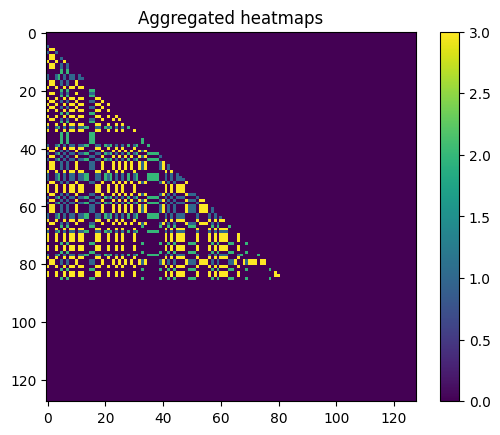

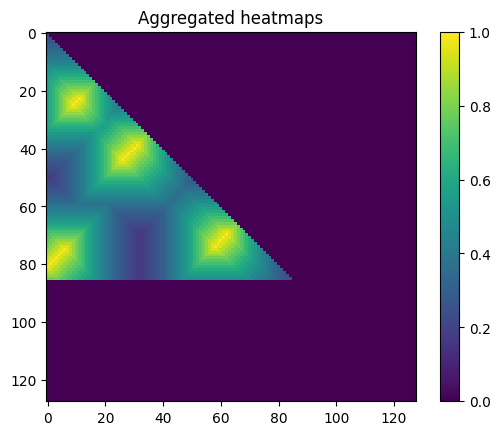

In [14]:
index = 6
visualize.heatmap(t["input"][0][index])
visualize.heatmap(t["output"][index])

### Secondary Structure Refiner